In [60]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl
import pandas as pd
import os
import sys
import argparse
import re
import seaborn as sns
from scipy import stats
# IMport cv2
import cv2
from skimage import io
from skimage import color
from skimage.segmentation import watershed
import scipy.io
import scipy.ndimage
import h5py

from scipy.ndimage import label, generate_binary_structure
from skimage.measure import regionprops
from skimage.io import imread, imshow

from skimage import measure, morphology
import math
from h5py_to_dict import h5py_to_dict
from getPrmDflt import getPrmDflt
from bwareaopen import bwareaopen
from get_con_seg import get_con_seg


# Get the path to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# # Append the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
# Append the parent directory to the system path
parent_parent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
if parent_parent_dir not in sys.path:
    sys.path.append(parent_parent_dir)
# Add to path parent_parent_dir/MLVcode
sys.path.append(os.path.join(parent_parent_dir, 'MLVcode'))
print("The current working directory is:")
print(os.getcwd())
print("The parent directory is:")
print(parent_dir)
print("The parent parent directory is:")
print(parent_parent_dir)
from mergeLineSegments import mergeLineSegments

The current working directory is:
/Users/aravind/Documents/BWL_github/July_PyMLV/pyMLV/demos/getLineDrawing
The parent directory is:
/Users/aravind/Documents/BWL_github/July_PyMLV/pyMLV/demos
The parent parent directory is:
/Users/aravind/Documents/BWL_github/July_PyMLV/pyMLV


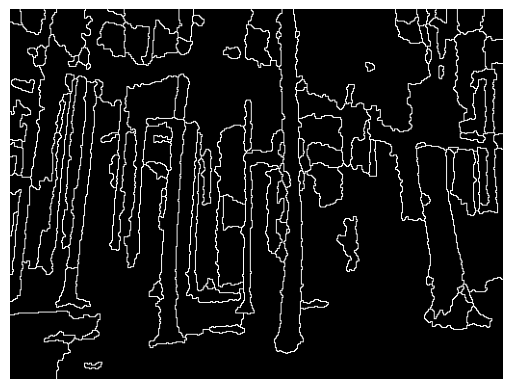

In [61]:
# Testing bwareaopen function
# # Load U_original.mat using scipy.io.loadmat
file_path = './U_original.mat'
U_orig = scipy.io.loadmat(file_path)
U_orig = U_orig['U_orig']
threshold_edge_strength = 0.85

F  = 1 - U_orig
    # F(F < threshold_edge_strength) = 0;
    # F(F >= threshold_edge_strength) = 1;
F[F < threshold_edge_strength] = 0
F[F >= threshold_edge_strength] = 1
# Invert F 
F = 1 - F
T = bwareaopen(F, 30)
# Display the image 
plt.imshow(T, cmap='gray')
plt.axis('off')
plt.show()

In [83]:
def spDetect(I=None, E= None, **kwargs):
    dfs = ['type','sticky', 'nIter',4, 'nThreads',4, 'k',512, 'alpha',.5, 'beta',.9, 'merge',0, 'bounds',1, 'seed',[] ]
    o = getPrmDflt(kwargs, dfs, 1)
    # If no input arguments, return the default parameters
    if I is None:
        print("No input arguments")
        return o
    type1 = o['type'][0].lower()
    assert type1 == 'w' or type1 == 's'
    sigs = [ o['k']*o['alpha']/1e4, 
            o['alpha']/1e4, 
            (1-o['alpha'])*o['beta'], 
            (1-o['alpha'])*(1-o['beta']) ]
    # print(sigs)
    I = cv2.imread('../images/example.jpg')
    h, w, _ = I.shape
    assert I.dtype == np.uint8 and I.shape[2] == 3

    if E is None:
        E = np.zeros((h, w), dtype=np.float32)
    
    assert E.dtype == np.float32 and E.shape == (h, w)
    
    # Placeholder for actual superpixel detection method
    if type1 == 'w':
        # Run watershed algorithm
        # gradient = sobel(E)
        S = watershed(convTri(E, 1))
        b = 1

    else:
        if o['seed'] is not None:
            S = o['seed']
            assert S.dtype == np.uint32 and S.shape == (h, w)
            if o['bounds']:
                # Placeholder for boundary refinement
                pass
        else:
            s = 0.5
            h1 = h - h % int(1 / s)
            w1 = w - w % int(1 / s)
            I0 = cv2.resize(I[:h1, :w1], (0, 0), fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
            E0 = cv2.resize(E[:h1, :w1], (0, 0), fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
            S = np.uint32(np.reshape(np.arange(h1 * w1 * s * s), (int(h1 * s), int(w1 * s))))

            # Refine superpixels at half resolution
            p = [o['nIter'] * 2, o['nThreads'], sigs[0] * s * s, sigs[1] / s / s, *sigs[2:]]
            # Placeholder for spDetectMex 'sticky' function
            # S = spDetectMex('sticky', S, convTri(I0, 1), E0, p)
            S = cv2.resize(S, (w, h), interpolation=cv2.INTER_NEAREST)
            S = np.uint32(np.pad(S, ((0, h - h1), (0, w - w1)), 'edge'))

        # Refine superpixels at full resolution
        p = [o['nIter'], o['nThreads'], *sigs]
        # Placeholder for spDetectMex 'sticky' function
        S = spDetectMex('sticky', S, convTri(I, 1), E, p)
        b = 0

    if o['bounds'] != b:
        # Placeholder for spDetectMex 'boundaries' function
        # S = spDetectMex('boundaries', S, E, opts['bounds'], opts['nThreads'])
        pass

    if o['merge'] > 0 and o['bounds']:
        # Placeholder for spDetectMex 'merge' function
        S = spDetectMex('merge', S, E, opts['merge'])
        pass

    V = None
    if 'V' in kwargs:
        # Placeholder for spDetectMex 'visualize' function
        V = spDetectMex('visualize', S, I, opts['bounds'])
        pass

    return S, V          
    

In [84]:
def traceLineDrawingFromRGB(fileName, img): 
    threshold_edge_strength = 0.85
    
    # Read image data
    if img is None:
        img = cv2.imread(fileName)
    
    imsize = img.shape
    vecLD = {}
    vecLD['imsize'] = imsize
    vecLD['originalImage'] = fileName
    # vecLD['lineMethod'] = 
    
    # Load the modelBsds.mat that contains the dictionary model
    file_path = 'modelBsds.mat'
    with h5py.File(file_path, 'r') as file:
        model = h5py_to_dict(file)
    model = model['model']
    model['opts']['nms'] = -1
    model['opts']['nThreads'] = 4
    model['opts']['multiscale'] = 0
    model['opts']['sharpen'] = 2
    model.keys()


    # set up opts for spDetect (see spDetect.m)
    opts = spDetect()
    opts['nThreads'] = 4  # number of computation threads
    opts['k'] = 512      # controls scale of superpixels (big k -> big sp)
    opts['alpha'] = .5   # relative importance of regularity versus data terms
    opts['beta'] = .9    # relative importance of edge versus color terms
    opts['merge'] = 0     # set to small value to merge nearby superpixels at end


    [E, _,_,segs] = edgesDetect(img, model)
    [S, _] = spDetect(img, E, opts)
    [_, _, U] = spAffinities(S, E, segs, opts['nThreads'])

    coverage = 0
    while coverage < 0.01 and threshold_edge_strength != 1:
        F = 1 - U
        F[F < threshold_edge_strength] = 0
        F[F >= threshold_edge_strength] = 1
        T = bwareaopen(~F, 30)
        F = ~T
        coverage = np.sum(F != 1) / (F.shape[0] * F.shape[1]) # Check this later
        threshold_edge_strength = threshold_edge_strength + 0.01
        
    image = 1 - F
    SegList = get_con_seg(image)  # Check this later
    
    all_boundary_points = np.column_stack(np.where(image != 0))

    vecLD = {}
    vecLD['numContours'] = len(SegList)
    vecLD['contours'] = []

    for i in range(len(SegList)):
        contour = SegList[i]
        indices = np.ravel_multi_index((contour[:, 0], contour[:, 1]), image.shape)
        all_boundary_points = np.setdiff1d(all_boundary_points, indices, axis=0)  # Check this later
        
        Ys = contour[:, 0]
        Xs = contour[:, 1]
        vecLD['contours'].append([Xs[:-1], Ys[:-1], Xs[1:], Ys[1:]])
                                
    vecLD = merge_line_segments(vecLD, 1)

In [85]:
# Open the MATLAB v7.3 file and convert to dictionary
file_path = 'modelBsds.mat'
with h5py.File(file_path, 'r') as file:
    model = h5py_to_dict(file)
model = model['model']
model['opts']['nms'] = -1
model['opts']['nThreads'] = 4
model['opts']['multiscale'] = 0
model['opts']['sharpen'] = 2
print(model.keys())

# set up opts for spDetect (see spDetect.m)
opts = spDetect()
opts['nThreads'] = 4  # number of computation threads
opts['k'] = 512      # controls scale of superpixels (big k -> big sp)
opts['alpha'] = .5   # relative importance of regularity versus data terms
opts['beta'] = .9    # relative importance of edge versus color terms
opts['merge'] = 0     # set to small value to merge nearby superpixels at end
opts

dict_keys(['child', 'count', 'depth', 'eBins', 'eBnds', 'fids', 'nSegs', 'opts', 'segs', 'thrs'])
No input arguments


{'type': 'sticky',
 'nIter': 4,
 'nThreads': 4,
 'k': 512,
 'alpha': 0.5,
 'beta': 0.9,
 'merge': 0,
 'bounds': 1,
 'seed': []}

Printing the keys of the model dictionary
dict_keys(['child', 'count', 'depth', 'eBins', 'eBnds', 'fids', 'nSegs', 'opts', 'segs', 'thrs'])
No input arguments
Printing the keys of the opts dictionary
dict_keys(['type', 'nIter', 'nThreads', 'k', 'alpha', 'beta', 'merge', 'bounds', 'seed'])


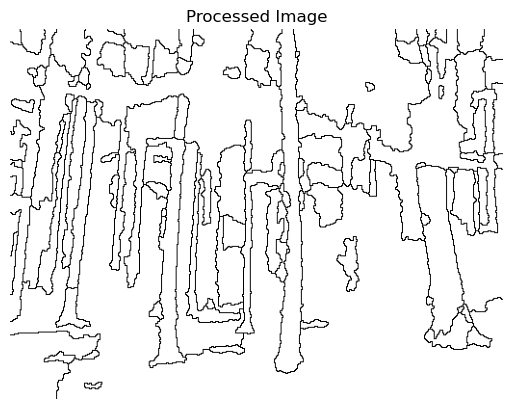

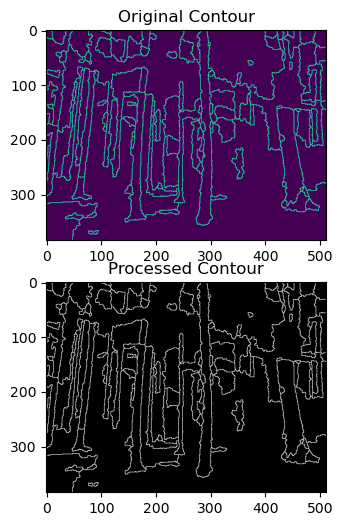

In [86]:
# Open the MATLAB v7.3 file and convert to dictionary
file_path = 'modelBsds.mat'
with h5py.File(file_path, 'r') as file:
    model = h5py_to_dict(file)
model = model['model']
model['opts']['nms'] = -1
model['opts']['nThreads'] = 4
model['opts']['multiscale'] = 0
model['opts']['sharpen'] = 2
print("Printing the keys of the model dictionary")
print(model.keys())

# set up opts for spDetect (see spDetect.m)
opts = spDetect()
opts['nThreads'] = 4  # number of computation threads
opts['k'] = 512      # controls scale of superpixels (big k -> big sp)
opts['alpha'] = .5   # relative importance of regularity versus data terms
opts['beta'] = .9    # relative importance of edge versus color terms
opts['merge'] = 0     # set to small value to merge nearby superpixels at end
print("Printing the keys of the opts dictionary")
print(opts.keys())
# Load U_original.mat using scipy.io.loadmat
file_path = './U_original.mat'
U_orig = scipy.io.loadmat(file_path)
U_orig = U_orig['U_orig']
threshold_edge_strength = 0.85

F  = 1 - U_orig
    # F(F < threshold_edge_strength) = 0;
    # F(F >= threshold_edge_strength) = 1;
F[F < threshold_edge_strength] = 0
F[F >= threshold_edge_strength] = 1
# Invert F 
F = 1 - F
T = bwareaopen(F, 30)
F = 1 - T
# Display the image 
plt.imshow(F, cmap='gray')
plt.title('Processed Image')
plt.axis('off')
plt.show()

# Load binary image
image = 1 - F
seg_list = get_con_seg(image, min_length=10) # Check this later

# Display original and processed images
plt.figure(figsize=(12, 6)).tight_layout()
plt.subplot(2, 1, 1)
plt.imshow(image)
plt.title('Original Contour')

plt.subplot(2, 1, 2)
cleaned_contour = morphology.label(image)
for segment in seg_list:
    cleaned_contour[segment[:, 0], segment[:, 1]] = 255
plt.imshow(cleaned_contour, cmap='gray')
plt.title('Processed Contour')

plt.show()

# EdgesDetect()

In [37]:
def im_pad(I, pad, pad_type):
    """
    Pad an image along its four boundaries.

    Parameters:
    I (ndarray): Input image (2D or 3D single, double or uint8 array).
    pad (int or tuple): Pad or crop amount. Can be a single int, a tuple of two ints, or a tuple of four ints.
    pad_type (str or int): Pad value or 'replicate', 'symmetric', 'circular'.

    Returns:
    J (ndarray): Padded image.
    """
    h, w = I.shape[:2]

    if isinstance(pad, int):
        pad = [pad, pad, pad, pad]
    elif len(pad) == 2:
        pad = [pad[0], pad[0], pad[1], pad[1]]
    elif len(pad) != 4:
        raise ValueError('pad must be an int, a tuple of two ints, or a tuple of four ints')

    if isinstance(pad_type, (int, float)):
        J = np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), mode='constant', constant_values=pad_type) if I.ndim == 3 else np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3])), mode='constant', constant_values=pad_type)
    elif pad_type == 'replicate':
        J = np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), mode='edge') if I.ndim == 3 else np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3])), mode='edge')
    elif pad_type == 'symmetric':
        J = np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), mode='reflect') if I.ndim == 3 else np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3])), mode='reflect')
    elif pad_type == 'circular':
        J = np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3]), (0, 0)), mode='wrap') if I.ndim == 3 else np.pad(I, ((pad[0], pad[1]), (pad[2], pad[3])), mode='wrap')
    else:
        raise ValueError('pad_type must be an int, "replicate", "symmetric", or "circular"')
    return J

In [38]:
def edgesDetect(I, model, nargout, nargin):
    # nargout = 4
    # nargin = 2
    opts = model['opts']
    opts['nTreesEval'] = min(opts['nTreesEval'], model['nTrees'])
    if 'sharpen' not in opts:
        opts['sharpen'] = 0
    if 'segs' not in model:
        model['segs'] = []
        model['nSegs'] = []
        
    opts['stride'] = max(opts['stride'], opts['shrink'])
    model['opts'] = opts
    
    if opts['multiscale']:
        print("Multiscale")
        # if multiscale run edgesDetect multiple times
        ss = 2.**np.arange(-1, 2)
        k = len(ss)
        # inds=cell(1,k); segs=inds;
        # siz=size(I); model.opts.multiscale=0; model.opts.nms=0; 
        inds = []
        for i in range(k):
            inds.append([])
        segs = inds
        siz = I.shape
        model['opts']['multiscale'] = 0
        model['opts']['nms'] = 0
        E = 0
        for i in range(k):
            s = ss[i]
            # Do bilinear interpolation and norm = 1
            I1 = cv2.resize(I, (0, 0), fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
            # if(nargout<4)
            #     [E1,~,inds{i}]=edgesDetect(I1,model);
            # else
            #     [E1,~,inds{i},segs{i}]=edgesDetect(I1,model);
            # end
            if nargout < 4:
                E1, _, inds[i] = edgesDetect(I1, model)
            else:
                E1, _, inds[i], segs[i] = edgesDetect(I1, model)
                
            E = E + cv2.resize(E1, siz, interpolation=cv2.INTER_LINEAR)
            
        E = E / k
        model['opts'] = opts 
    else:
        print("No Multiscale")
        # Pad image, making divisible by 4
        siz = I.shape
        r = opts['imWidth']/2
        p = [r, r, r, r]
        # p([2 4])=p([2 4])+mod(4-mod(siz(1:2)+2*r,4),4);
        # I = imPad(I,p,'symmetric');
        p[1] = p[1] + np.mod(4 - np.mod(siz[0:2] + 2*r, 4), 4) # Check this later
        p[3] = p[3] + np.mod(4 - np.mod(siz[0:2] + 2*r, 4), 4)
        I = im_pad(I, p, 'symmetric') # Check this later
        # Compute features and apply forest to image
        chnsReg, chnsSim = edgesChns(I, opts) # Need to implement this function
        s = opts['sharpen']
        if s:
            # Check if I is rgb
            if I.ndim == 3:
                # Normalise to [0,1]
                I = I / 255
        if nargout < 4:
            E, inds = edgesDetectMex(model, I, chnsReg, chnsSim)
        else:
            E, inds, segs = edgesDetectMex(model, I, chnsReg, chnsSim)
            
        # t=opts.stride^2/opts.gtWidth^2/opts.nTreesEval;
        # r=opts.gtWidth/2;
        t = opts['stride']**2 / opts['gtWidth']**2 / opts['nTreesEval']
        r = opts['gtWidth'] / 2
        if s != 0:
            t = t * 2
        elif s == 1:
            t = t * 1.8
        else:
            t = t * 1.66
        # E=E(1+r:siz(1)+r,1+r:siz(2)+r,:)*t;
        # E=convTri(E,1);
        E = E[1 + r:siz[0] + r, 1 + r:siz[1] + r, :] * t
        E = convTri(E, 1)
    
    # Compute approximate orientation O from edges E
    if opts['nms'] == -1:
        print("Opts.nms == -1")
        O = []
    elif nargout > 1 or opts['nms']:
        print("Gradients being calculated")
        # [Ox,Oy]=gradient2(convTri(E,4));
        # [Oxx,~]=gradient2(Ox);
        # [Oxy,Oyy]=gradient2(Oy);
        # O=mod(atan(Oyy.*sign(-Oxy)./(Oxx+1e-5)),pi);
        E_temp = convTri(E, 4)
        Ox, Oy = np.gradient(E_temp)
        Oxx, _ = np.gradient(Ox)
        Oxy, Oyy = np.gradient(Oy)
        O = np.mod(np.arctan(Oyy * np.sign(-Oxy) / (Oxx + 1e-5)), np.pi)
    
    # Perform nms
    if opts['nms']:
        print("Non-maximum suppression")
        E = edgesNms(E, 0, 1, 5, 1.01, opts['nThreads'])
    
    if nargout == 1:
        print("Returning E")
        return E
    elif nargout == 2:
        print("Returning E and O")
        return E, O
    elif nargout == 3:
        print("Returning E, O and inds")
        return E, O, inds
    else:
        print("Returning E, O, inds and segs")
        return E, O, inds, segs

# spAffinities

In [17]:
def edges(E, S, h, w, A):
    """
    Determine edge strengths for an image based on superpixels and an affinity matrix.
    
    Parameters:
    E (ndarray): Edge strength matrix to be updated.
    S (ndarray): Superpixel label matrix.
    h (int): Height of the image.
    w (int): Width of the image.
    A (ndarray): Affinity matrix.
    
    Returns:
    ndarray: Updated edge strength matrix.
    """
    # Determine the maximum superpixel label
    m = S.max()
    
    # Iterate over each pixel
    for x in range(w):
        for y in range(h):
            # Skip if the pixel is already processed or non-zero in S
            if S[y, x] != 0:
                continue
            
            # Initialize edge strength
            E[y, x] = 0.01
            
            # Collect neighborhood indices
            x_indices = [x-1, x, x+1]
            y_indices = [y-1, y, y+1]
            
            # Ensure the indices are within image boundaries
            x_indices = [xi for xi in x_indices if 0 <= xi < w]
            y_indices = [yi for yi in y_indices if 0 <= yi < h]
            
            # Extract the neighborhood
            neighborhood = S[np.ix_(y_indices, x_indices)]
            
            # Collect unique superpixels, excluding zero
            unique_superpixels = np.unique(neighborhood[neighborhood > 0]) - 1 # Adjust for zero-based indexing
            
            # Calculate edge strength using the affinity matrix
            if len(unique_superpixels) > 1:
                # Generate all pairs of unique superpixels
                n_unique = len(unique_superpixels)
                pairs = np.array(np.triu_indices(n_unique, 1)).T
                pairs = np.column_stack((unique_superpixels[pairs[:, 0]] + 1, unique_superpixels[pairs[:, 1]] + 1)) # Adjust back to 1-based indexing
                
                # Compute the linear indices for the affinity matrix
                linear_indices = np.ravel_multi_index((pairs[:, 0]-1, pairs[:, 1]-1), (m, m))
                
                # Update edge strength
                for k in range(len(linear_indices)):
                    E[y, x] = max(1 - A.flat[linear_indices[k]], E[y, x])
    
    return E

# Example usage:
# Load E_spAffinities.mat
E = scipy.io.loadmat('Data_spAffinities/E_spAffinities.mat')
E = E['E_spAffinities']
S = scipy.io.loadmat('Data_spAffinities/S_spAffinities.mat')
S = S['S_spAffinities']
A = scipy.io.loadmat('Data_spAffinities/A_spAffinities.mat')
A = A['A_spAffinities']
h, w = S.shape
updated_E = edges(E, S, h, w, A)
print(updated_E)



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.07574421 0.         0.        ]
 ...
 [0.         0.         0.22256744 ... 0.         0.         0.        ]
 [0.         0.         0.22256744 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [56]:
def sticky(S, h, w, I, E, prm):
    # Get additional parameters
    maxIter = int(prm[0])
    nThreads = int(prm[1])
    sigs = float(prm[2])
    sigx = float(prm[3])
    sige = float(prm[4])
    sigc = float(prm[5])
    # Round off to 5 decimal places
    sigs = round(sigs, 5)
    sigx = round(sigx, 5)
    sige = round(sige, 5)
    sigc = round(sigc, 5)
    # Print the parameters
    print("maxIter: ", maxIter)
    print("nThreads: ", nThreads)
    print("sigs: ", sigs)
    print("sigx: ", sigx)
    print("sige: ", sige)
    print("sigc: ", sigc)

    # Initialize mus and ns
    m = int(np.max(S)) + 1
    ns = np.zeros(m, dtype=np.float32)
    mus = np.zeros((m, 5), dtype=np.float32)

    for x in range(w):
        for y in range(h):
            i = S[y, x]
            ns[i] += 1
            mus[i, 0] += x
            mus[i, 1] += y
            for z in range(3):
                mus[i, z + 2] += I[y, x, z]

    for i in range(m):
        for z in range(5):
            if ns[i] != 0:
                mus[i, z] /= ns[i]

    # Iterate moving boundaries
    changed = True
    iter = 0
    while changed and iter < maxIter:
        changed = False
        for xi in range(w):
            for y in range(h):
                x = xi
                s = S[y, x]

                x0 = x - 1 if x > 0 else x
                x1 = x + 1 if x < w - 1 else x
                y0 = y - 1 if y > 0 else y
                y1 = y + 1 if y < h - 1 else y

                T = [S[y, x0], S[y, x1], S[y0, x], S[y1, x]]
                if s == T[0] and s == T[1] and s == T[2] and s == T[3]:
                    continue

                # Compute error of each sp label, store best
                vs = np.array([float(x), float(y)] + [I[y, x, j] for j in range(3)], dtype=np.float32)
                es = np.array([E[y, x0], E[y, x1], E[y0, x], E[y1, x]], dtype=np.float32)

                dBest = 1e10
                sBest = T[0] + 1

                for i in range(4):
                    t = T[i]
                    if t == sBest:
                        continue

                    e = 1e10
                    for j in range(4):
                        if T[j] != t:
                            e = min(e, es[j])

                    ds = np.zeros(5, dtype=np.float32)
                    for j in range(5):
                        ds[j] = mus[t, j] - vs[j]
                        ds[j] *= ds[j]

                    d = (ds[0] + ds[1]) * sigx + (ds[2] + ds[3] + ds[4]) * sigc - e * sige
                    d += sigs / ns[t]

                    if d < dBest:
                        dBest = d
                        sBest = t

                # Assign pixel to closest sp, update new and old sp
                if sBest != s:
                    t = sBest
                    changed = True
                    ns[s] -= 1
                    ns[t] += 1
                    S[y, x] = t
                    for j in range(5):
                        mus[s, j] = (mus[s, j] * (ns[s] + 1) - vs[j]) / ns[s]
                    for j in range(5):
                        mus[t, j] = (mus[t, j] * (ns[t] - 1) + vs[j]) / ns[t]

        iter += 1

    return S


# Example usage
S = scipy.io.loadmat('Data_pre_sticky1/pre_sticky1_S.mat')
S = S['pre_sticky1_S']
I = scipy.io.loadmat('Data_pre_sticky1/pre_sticky1_I.mat')
I = I['pre_sticky1_I']
E = scipy.io.loadmat('Data_pre_sticky1/pre_sticky1_E0.mat')
E = E['pre_sticky1_E0']
prm = scipy.io.loadmat('Data_pre_sticky1/pre_sticky1_p.mat')
prm = prm['pre_sticky1_p'][0]
print("Original S:")
print(S)
h, w = S.shape

adjusted_S = sticky(S, h, w, I, E, prm)

# print("Adjusted S:")
# print(adjusted_S)
# Print size of S
print("Size of S:")
print(adjusted_S.shape)
# Print 10x10 region of S
# print("Printing the first 10 rows and columns of S")
# print(adjusted_S[:10, :10])

Original S:
[[    0   192   384 ... 48576 48768 48960]
 [    1   193   385 ... 48577 48769 48961]
 [    2   194   386 ... 48578 48770 48962]
 ...
 [  189   381   573 ... 48765 48957 49149]
 [  190   382   574 ... 48766 48958 49150]
 [  191   383   575 ... 48767 48959 49151]]
maxIter:  8
nThreads:  4
sigs:  0.0064
sigx:  0.0002
sige:  0.45
sigc:  0.05


/var/folders/f_/dg0mg7zs2yn54_n_kfn57g3w0000gn/T/ipykernel_57335/3339915618.py:97: RuntimeWarning: invalid value encountered in scalar divide
  mus[s, j] = (mus[s, j] * (ns[s] + 1) - vs[j]) / ns[s]
/var/folders/f_/dg0mg7zs2yn54_n_kfn57g3w0000gn/T/ipykernel_57335/3339915618.py:97: RuntimeWarning: divide by zero encountered in scalar divide
  mus[s, j] = (mus[s, j] * (ns[s] + 1) - vs[j]) / ns[s]


Size of S:
(192, 256)


In [57]:
# Load S_aftersitcky.mat using scipy.io.loadmat
file_path = 'Data_pre_sticky1/S_after_sticky_prelabel.mat'
S_after_sticky_prelabel = scipy.io.loadmat(file_path)
S_after_sticky_prelabel = S_after_sticky_prelabel['S_after_sticky_prelabel']
# Print 10x10 region of S_after_sticky_prelabel
# print("Printing the first 10 rows and columns of S_after_sticky_prelabel")
# print(S_after_sticky_prelabel[:10, :10])
# # Print 10x10 of adjusted S
# print("Printing the first 10 rows and columns of adjusted S")
# print(adjusted_S[:10, :10])
# Print indices where S_after_sticky_prelabel and adjusted S are different
print("Indices where S_after_sticky_prelabel and adjusted S are different")
print(np.where(S_after_sticky_prelabel != adjusted_S))
# Print the row, column and value where S_after_sticky_prelabel and adjusted S are different
indices = np.column_stack(np.where(S_after_sticky_prelabel != adjusted_S))
for index in indices:
    print(f"Row: {index[0]}, Column: {index[1]}, Value: {adjusted_S[index[0], index[1]]}, Original Value: {S_after_sticky_prelabel[index[0], index[1]]}")

Indices where S_after_sticky_prelabel and adjusted S are different
(array([62, 63, 63, 64, 64, 64, 65, 65, 66]), array([156, 156, 157, 156, 157, 158, 156, 157, 157]))
Row: 62, Column: 156, Value: 30209, Original Value: 30208
Row: 63, Column: 156, Value: 30209, Original Value: 30208
Row: 63, Column: 157, Value: 30209, Original Value: 30208
Row: 64, Column: 156, Value: 30209, Original Value: 30208
Row: 64, Column: 157, Value: 30209, Original Value: 30208
Row: 64, Column: 158, Value: 30209, Original Value: 30590
Row: 65, Column: 156, Value: 30209, Original Value: 30208
Row: 65, Column: 157, Value: 30209, Original Value: 30208
Row: 66, Column: 157, Value: 30209, Original Value: 30208


In [58]:
def relabel(S, h, w):
    """
    Relabel the regions in the image based on connectivity.

    Parameters:
    S (ndarray): Input label matrix.
    h (int): Height of the image.
    w (int): Width of the image.

    Returns:
    ndarray: Relabeled matrix.
    """
    T = np.zeros((h, w), dtype=np.uint32)  # Temporary array for new labels
    map = np.zeros(h * w // 2, dtype=np.uint32)

    m = np.uint32(1)  # Initial label
    T[0, 0] = m  # Assign the first element
    m += 1

    # Relabel based on vertical connectivity for the first column
    for y in range(1, h):
        if S[y, 0] == S[y - 1, 0]:
            T[y, 0] = T[y - 1, 0]
        else:
            T[y, 0] = m
            m += 1

    # Relabel based on horizontal and vertical connectivity for each column
    for x in range(1, w):
        z = x * h
        T[0, x] = T[0, x - 1] if S[0, x] == S[0, x - 1] else m
        if S[0, x] != S[0, x - 1]:
            m += 1

        for y in range(1, h):
            z = y + x * h
            if S[y, x] == S[y, x - 1]:
                T[y, x] = T[y, x - 1]
            elif S[y, x] == S[y - 1, x]:
                T[y, x] = T[y - 1, x]
            else:
                T[y, x] = m
                m += 1

            # Handle the diagonal connectivity and resolve conflicts
            if T[y, x - 1] != T[y - 1, x] and S[y, x - 1] == S[y, x] and S[y - 1, x] == S[y, x]:
                t1 = T[y, x - 1]
                while map[t1] != 0:
                    t1 = map[t1]
                t2 = T[y - 1, x]
                while map[t2] != 0:
                    t2 = map[t2]
                if t1 != t2:
                    if t1 < t2:
                        map[t2] = t1
                        T[y, x] = t1
                    else:
                        map[t1] = t2
                        T[y, x] = t2

    # Flatten the mapping to ensure direct mapping to final labels
    m1 = np.uint32(0)
    for t in range(1, m):
        if map[t] != 0:
            map[t] = map[map[t]]
        else:
            map[t] = m1
            m1 += 1

    # Apply the final mapping to S
    for x in range(w):
        for y in range(h):
            S[y, x] = map[T[y, x]]

    return S

# Example usage
# h, w = adjusted_S.shape
h, w = S_after_sticky_prelabel.shape

print("Original S:")
# print(adjusted_S)
# print(adjusted_S[0:5, 0:5])
print(S_after_sticky_prelabel)
print(S_after_sticky_prelabel[0:5, 0:5])

# relabeled_S = relabel(adjusted_S, h, w)
relabeled_S = relabel(S_after_sticky_prelabel, h, w)

print("Relabeled S:")
print(relabeled_S)


Original S:
[[    1     1     1 ... 48577 48960 48960]
 [    1     1     1 ... 48577 48960 48960]
 [    1     1     1 ... 48577 48960 48960]
 ...
 [  183   183   766 ... 49147 49147 49147]
 [  191   766   766 ... 48190 48190 49151]
 [  191   191   766 ... 48190 48190 49151]]
[[  1   1   1 576 576]
 [  1   1   1 576 576]
 [  1   1   1 580 580]
 [  1   1 580 580 580]
 [  4   4 580 580 580]]
Relabeled S:
[[   0    0    0 ... 2245 2287 2287]
 [   0    0    0 ... 2245 2287 2287]
 [   0    0    0 ... 2245 2287 2287]
 ...
 [  45   45   54 ... 2273 2273 2273]
 [  46   54   54 ... 2236 2236 2294]
 [  46   46   54 ... 2236 2236 2294]]


In [59]:
# S_actual = scipy.io.loadmat('Data_pre_sticky1/S_calc.mat')
# S_actual = S_actual['S_calc']
# print("Actual S print 10x10:")
# print(S_actual)
# print("Relabeled S print 10x10:")
# print(relabeled_S)
# # Print indices where S_actual and relabeled S are different
# print("Indices where S_actual and relabeled S are different")
# # Print the row, column and value where S_actual and relabeled S are different
# indices = np.column_stack(np.where(S_actual != relabeled_S))
# for index in indices:
#     print(f"Row: {index[0]}, Column: {index[1]}, Value: {relabeled_S[index[0], index[1]]}, Original Value: {S_actual[index[0], index[1]]}")
# # Print how many labels are different
# print("Number of labels that are different")
# print(np.sum(S_actual != relabeled_S))

In [79]:
def upsampleEdges(E0):
    # upsample E by factor of two while mostly keeping edges thin
    h, w = E0.shape
    h = 2 * h
    w = 2 * w
    E = np.zeros((h, w))
    E[0:h - 1:2, 0:w - 1:2] = E0 # Check this later
    E[0:h - 1:2, 1:w - 2:2] = np.minimum(E0[:, 0:-1], E0[:, 1:]) # Check this later
    E[h - 1, :] = E[h - 2, :] # Check this later
    E[1:h - 2:2, 0:w - 1:2] = np.minimum(E0[0:-1, :], E0[1:, :]) # Check this later
    
    # Remove single pixel segments created by thick edges in E0 (2x2 blocks)
    A = np.ones((2, 2)) / 4
    A = scipy.ndimage.convolve((E0 > 0).astype(np.float32), A) == 1
    xs, ys = np.where(A)
    
    for i in range(len(xs)):
        # x=(xs(i)-1)*2; 
        x = (xs[i] - 1) * 2
        # y=(ys(i)-1)*2; 
        y = (ys[i] - 1) * 2
        # es=ones(2,4)+1;
        es = np.ones((2, 4)) + 1
        # if(x>2   && y>2  )
        #   es(:,1)=[E(x-2,y-1) E(x-1,y-2)]; 
        # end
        if x > 2 and y > 2:
            es[:, 0] = [E[x - 2, y - 1], E[x - 1, y - 2]]
        if x < h - 2 and y > 2:
            es[:, 1] = [E[x + 2, y - 1], E[x + 1, y - 2]]
        if x < h - 2 and y < w - 2:
            es[:, 2] = [E[x + 2, y + 1], E[x + 1, y + 2]]
        if x > 2 and y < w - 2:
            es[:, 3] = [E[x - 2, y + 1], E[x - 1, y + 2]]
        e, j = np.min(np.max(es, axis=0))
        if j == 1 or j == 4:
            x1 = x - 1
        else:
            x1 = x + 1
        if j == 1 or j == 2:
            y1 = y - 1
        else:
            y1 = y + 1
        E[x, y1] = e
        E[x1, y] = e
        E[x1, y1] = e
        if es[0, j] < es[1, j]:
            E[x, y1] = 0
        else:
            E[x1, y] = 0
    return E

def computeUcm(E):
    E = upsampleEdges(E)
    print("Upsample edges done")
    S = measure.label(E == 0, connectivity=2) - 1 # S=bwlabel(E==0,8); Check this later
    S = S[1::2, 1::2]
    S[-1, :] = S[-2, :]
    S[:, -1] = S[:, -2]
    E = np.pad(E, ((1, 1), (1, 1)), mode='edge')
    U = ucm_mean_pb(E, S) # Need to implement this function
    U = U[0:-2:2, 0:-2:2]
    return U


def spAffinities(S, E, segs, nThreads=4, nargout):
    nargout = 3
    A = spDetectmex3('affinities', S, E, segs, nThreads) # Need to implement this function
    if nargout > 1:
        E = spDetectmex3('edges', S, A) # Need to implement this function
    if nargout > 2:
        U = computeUcm(E)
        
    if nargout == 1:
        return A
    elif nargout == 2:
        return A, E
    else:
        return A, E, U

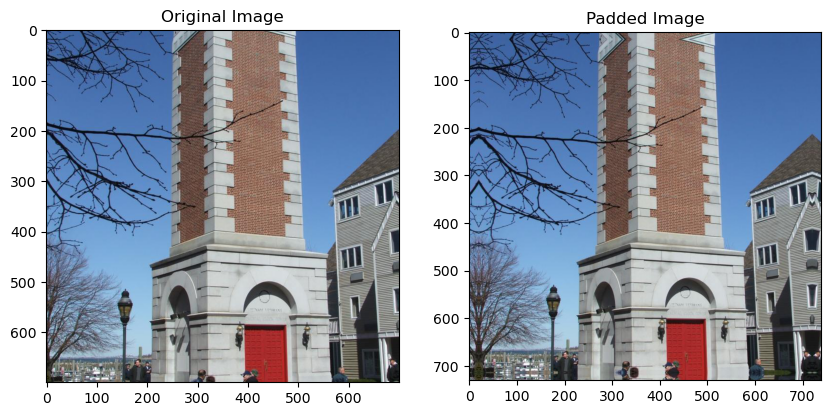

In [40]:
# Testing the padding function
import matplotlib.pyplot as plt
from skimage.io import imread

# Load example image
I = imread('../../images/example.jpg')

# Pad the image
pad = (15, 20)
pad_type = 'symmetric'
J = im_pad(I, pad, pad_type)

# Display original and padded images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(I, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(J, cmap='gray')
plt.title('Padded Image')

plt.show()
